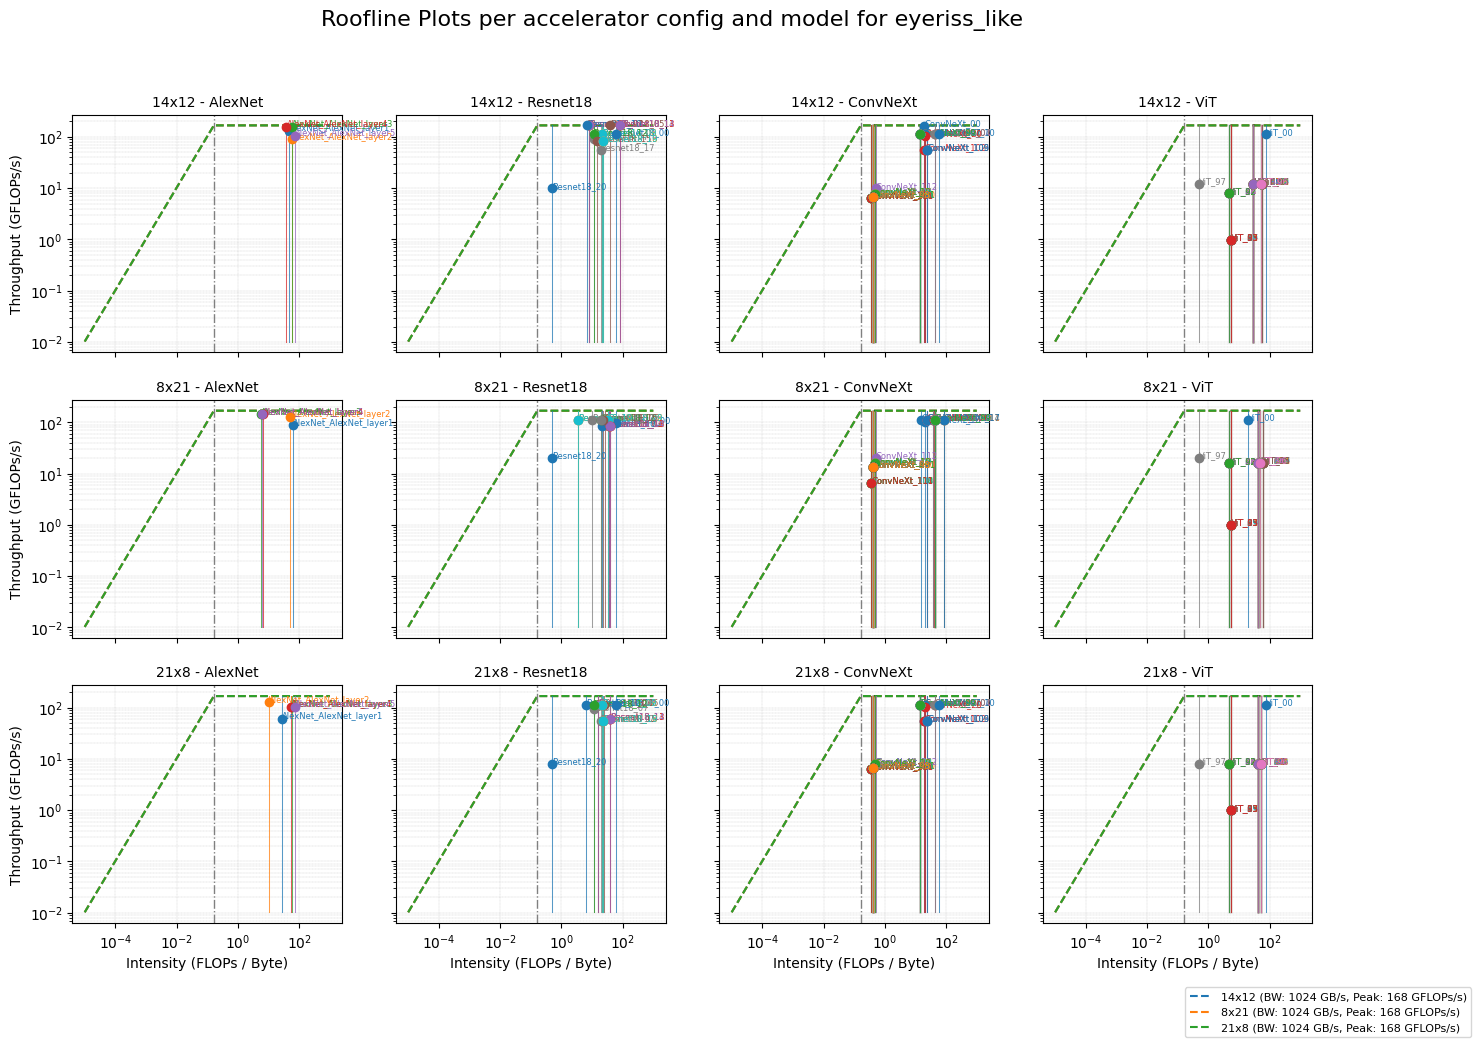

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import ast

accelerator = "eyeriss_like"
# accelerator = "simple_output_stationary"
# accelerator = "eyeriss_like_deployment"

# Setup
models = ["AlexNet", "Resnet18", "ConvNeXt", "ViT"]

memory_bandwidth = {
    # "3060TensorCore": 192,
    # "3090TensorCore": 384,
    # "V100TensorCore": 512,
    # "A100TensorCore": 5120,
    "14x12": 1024,
    "8x21": 1024,
    "21x8": 1024
}

# boost_ghz = {
#     "3060": 1.777,
#     "4090": 2.520,
#     "H200SXM": 1.980,
#     "base_eyeriss": 168,
#     "8x21": 168,
#     "21x8": 168
# }

peak_gflops = {
    # "V100TensorCore": 8 * 16,
    # "A100TensorCore": 16 * 32,
    # "3060TensorCore": 16 * 32,
    # "3090TensorCore": 16 * 32,
    "14x12": 168,
    "8x21": 168,
    "21x8": 168
}

# Compute pivot points
pivots = {k: peak_gflops[k] / v for k, v in memory_bandwidth.items()}

n_rows = len(memory_bandwidth)
n_cols = len(models)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3.5 * n_rows), sharex=True, sharey=True)
x_vals = np.logspace(-5, 3, 500)
cmap = plt.get_cmap("tab10")


for row_idx, (accel, bw) in enumerate(memory_bandwidth.items()):
    for col_idx, model in enumerate(models):
        ax = axes[row_idx][col_idx]
        path = f"./{accelerator}_outputs/{accel}_{model}/layer_stats.csv"
        if not os.path.exists(path):
            ax.set_title(f"{accel} - {model}\n[Missing Data]", fontsize=10, color='red')
            ax.set_axis_off()
            continue

        df = pd.read_csv(path)
        df["Throughput"] = (df["total_ops"] / df["Cycles"]) / 2
        df["Throughput"] = df["Throughput"].clip(upper=peak_gflops[accel])
        # df["Intensity"] = df["optimal_op_per_byte"]
        # print(df["DRAM_intensity"])
        df["Intensity"] = df["DRAM_intensity"].apply(lambda x: ast.literal_eval(x)["Op per Byte"])
        df["Intensity"] = df["Intensity"] / 2


        # Roofline curves
        min_roofline = float("inf")
        for accel_temp, bw_temp in memory_bandwidth.items():
            peak = peak_gflops[accel_temp]
            pivot = pivots[accel_temp]
            y_vals = np.minimum(bw_temp * x_vals, peak)
            min_roofline = min(min_roofline, min(y_vals))
            if row_idx == 0 and col_idx == 0:
                ax.plot(x_vals, y_vals, label=f"{accel_temp} (BW: {bw_temp} GB/s, Peak: {peak} GFLOPs/s)", linestyle="--")
            else:
                ax.plot(x_vals, y_vals, linestyle="--")
            if accel_temp == accel:
                ax.axvline(x=pivot, color="grey", linestyle="dashdot", linewidth=1)
            # ax.text(pivot, 0.6 * peak, f"({accel_temp})", rotation=90, va="top", fontsize=10, color="black")

        # Scatter layer points with colored stems
        for i, (_, row) in enumerate(df.iterrows()):
            intensity = row["Intensity"]
            throughput = row["Throughput"]
            roofline_y = min(bw * intensity, peak_gflops[accel])
            color = cmap(i % 10)
            
            # Stem line
            ax.plot([intensity, intensity], [min_roofline, roofline_y], color=color, linewidth=0.75, alpha=0.75)
            # Scatter point
            ax.scatter(intensity, throughput, color=color, zorder=5)
            # Label
            ax.text(intensity, throughput, row["layer"], fontsize=6, color=color)

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.grid(True, which="both", linestyle="--", linewidth=0.2)

        if row_idx == n_rows - 1:
            ax.set_xlabel("Intensity (FLOPs / Byte)", fontsize=10)
        if col_idx == 0:
            ax.set_ylabel("Throughput (GFLOPs/s)", fontsize=10)

        ax.set_title(f"{accel} - {model}", fontsize=10)

# Final layout
fig.suptitle(f"Roofline Plots per accelerator config and model for {accelerator}", fontsize=16)
fig.legend(loc="lower right", fontsize=8)

# plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(f"{accelerator}_results.png", dpi=300)
plt.show()


In [3]:
accelerator_configs = [
    "3060TensorCore",
    "3090TensorCore",
    "V100TensorCore",
    "A100TensorCore",
    "14x12",
    "8x21",
    "21x8"
]

total_results = []

for model in models:
    for accel in accelerator_configs:
        path = f"./{accelerator}_outputs/{accel}_{model}/layer_stats.csv"
        df = pd.read_csv(path)
        # print(df.columns)
        total_cycles = df.Cycles.sum()
        df["eval_weightings"] = df.Cycles / total_cycles
        total_results.append({
            "model": model,
            "accelerator": accel,
            "total_cycles": total_cycles,
            "total_energy": df["Energy (uJ)"].sum(),
            "cycles_per_layer (weighted average)": np.sum(df.eval_weightings * df.Cycles),
            "utilization_per_layer (weighted average)": np.sum(df.eval_weightings * df["Utilization (%)"]),
            "energy_per_layer (weighted average)": np.sum(df.eval_weightings * df["Energy (uJ)"]),
        })
    # break

df = pd.DataFrame(total_results)
df.to_csv(f"{accelerator}_stats_results.csv", index=False)
df

,model,accelerator,total_cycles,total_energy,cycles_per_layer (weighted average),utilization_per_layer (weighted average),energy_per_layer (weighted average)
0,AlexNet,3060TensorCore,3.521980e+06,11649.48,8.796178e+05,59.705340,2670.521208
1,AlexNet,3090TensorCore,3.521980e+06,11649.48,8.796178e+05,59.705340,2670.521208
2,AlexNet,V100TensorCore,1.170587e+07,11708.38,2.800535e+06,71.854597,2599.651557
3,AlexNet,A100TensorCore,3.521980e+06,11649.71,8.796178e+05,59.705340,2670.565363
4,AlexNet,14x12,9.609096e+06,9601.19,3.169632e+06,66.691540,2729.772152
5,AlexNet,8x21,8.331276e+06,14973.00,2.191917e+06,76.919223,3455.659930
6,AlexNet,21x8,1.028806e+07,11988.26,2.344057e+06,62.287812,3104.995050
7,Resnet18,3060TensorCore,5.828800e+06,26273.90,3.700542e+05,60.785630,1420.988381
8,Resnet18,3090TensorCore,5.828800e+06,26273.90,3.700542e+05,60.785630,1420.988381
9,Resnet18,V100TensorCore,1.895552e+07,23793.64,1.166856e+06,74.763983,1380.987963
